In [1]:
using Pkg
Pkg.activate(".")
#for pkg in ["HTTP", "JSON", "Distributions", "Optim", "Random", "BlackBoxOptim", "ForwardDiff", "Integrals", "Roots", "StatsPlots", "DelimitedFiles", "PrettyTables", "DataStructures"]
#    Pkg.add(pkg)
#end
Pkg.instantiate()

  Activating project at `C:\Users\jbrig\Documents\mapinator`
Precompiling project...
  ✓ XSLT_jll
  ✓ Xorg_libxcb_jll
  ✓ Xorg_xcb_util_jll
  ✓ Xorg_libX11_jll
  ✓ Xorg_xcb_util_keysyms_jll
  ✓ Xorg_xcb_util_image_jll
  ✓ Xorg_xcb_util_renderutil_jll
  ✓ Xorg_xcb_util_wm_jll
  ✓ Xorg_libXrender_jll
  ✓ Xorg_libxkbfile_jll
  ✓ Xorg_libXext_jll
  ✓ Xorg_libXfixes_jll
  ✓ Xorg_xcb_util_cursor_jll
  ✓ Libglvnd_jll
  ✓ Xorg_libXinerama_jll
  ✓ Xorg_xkbcomp_jll
  ✓ Xorg_libXcursor_jll
  ✓ Xorg_libXrandr_jll
  ✓ Xorg_libXi_jll
  ✓ Xorg_xkeyboard_config_jll
  ✓ GLFW_jll
  ✓ xkbcommon_jll
  ✓ Vulkan_Loader_jll
  ✓ Qt6Base_jll
  ✓ Cairo_jll
  ✓ HarfBuzz_jll
  ✓ libass_jll
  ✓ FFMPEG_jll
  ✓ FFMPEG
  ✓ GR_jll
  ✓ GR
  ✓ Plots
  ✓ Plots → UnitfulExt
  ✓ StatsPlots
  34 dependencies successfully precompiled in 215 seconds. 218 already precompiled.


This notebook executes the complete estimation procedure required by The Mapinator Classification (Peters and Yu, 2023, work in progress), starting from placements data and ending with model estimates. Various components of this notebook can be altered to create different estimations under different constraints.

This notebook requires a multithreaded kernel; see https://julialang.github.io/IJulia.jl/stable/manual/installation/#Installing-additional-Julia-kernels.

The code for converting API data for use with estimation is adapted from [a notebook](https://github.com/jbrightuniverse/mapinator/blob/master/estimation/2023_summer_projects/api_to_mapinator_julia.ipynb) written by Silas Kwok.

We start by retrieving placements data from the API.

In [2]:
"""
SBM API Data Filter (Julia Version)
Adapted from James Yuming Yu (5 June 2023)

Silas Kwok, 31 July 2023

Adapted and modified for use with full estimation by James Yu, 17 September 2023
"""

using HTTP, JSON
DEBUG_LEVEL = 1

[ Info: Precompiling HTTP [cd3eb016-35fb-5094-929b-558a96fad6f3]


1

In [3]:
function matches(keywords, phrase)
    # checks if any of the keywords are in the phrase
    for keyword in keywords
        if occursin(keyword, phrase)
            return true
        end
    end
    return false
end

matches (generic function with 1 method)

### STEP 1a
Retrieve the placement outcomes.

In [4]:
# NOTE: request times out after 120 seconds. If the data takes longer than 120s to download, adjust the timeout.
placements = nothing
try
    mapinator_data = HTTP.get("https://support.econjobmarket.org/api/mapinator", timeout = 120)
    placements = JSON.parse(String(mapinator_data.body))
catch e
    error("Failed to retrieve data from the API: $e")
end

25644-element Vector{Any}:
 Dict{String, Any}("to_shortname" => "Economics, Tsinghua University", "created_at" => "2019-07-02 15:40:46", "to_name" => "Tsinghua University", "to_department" => "Department of Economics, School of Economics and Management", "to_latitude" => 39.999567, "name" => "Development; Growth", "category_id" => 1, "from_shortname" => "Economics, Univ of Michigan", "to_oid" => 623, "description" => "Academic organization (economics department)"…)
 Dict{String, Any}("to_shortname" => "Economics, Amherst College", "created_at" => "2019-07-02 19:38:17", "to_name" => "Amherst College", "to_department" => "Economics", "to_latitude" => 42.3709104, "name" => "Development; Growth", "category_id" => 1, "from_shortname" => "Economics, Univ of Michigan", "to_oid" => 3503, "description" => "Academic organization (economics department)"…)
 Dict{String, Any}("to_shortname" => "Int Food Policy Res Institute", "created_at" => "2019-07-02 19:40:39", "to_name" => "International Food P

### STEP 1b
Group placements by applicant ID and eliminate "oid 893" positions (Ocean and Crow).

In [5]:
# TODO: are the json fields strictly typed? is there a way to easily compensate if the variable types change?

applicant_outcomes = Dict{Any, Vector}()
applicant_ids = Set{Any}()
num_outcomes_selected = 0

for outcome in placements
    push!(applicant_ids, outcome["aid"])
    if outcome["to_oid"] != 893
        push!(get!(applicant_outcomes, outcome["aid"], Vector()), outcome)
        num_outcomes_selected += 1
    end
end

if DEBUG_LEVEL > 0
    println("  ", length(placements), " total placement outcomes")
    println("  -", length(placements) - num_outcomes_selected, " outcomes at Ocean and Crow")
    println("  ", num_outcomes_selected, " outcomes not at Ocean and Crow")
    println()
    println("  ", length(applicant_ids), " total applicants with placements")
    println("  -", length(applicant_ids) - length(applicant_outcomes), " total applicants with exclusively outcomes at Ocean and Crow")
    println("  ", length(applicant_outcomes), " applicants with outcomes not at Ocean and Crow")
end

  25644 total placement outcomes
  -4427 outcomes at Ocean and Crow
  21217 outcomes not at Ocean and Crow

  18473 total applicants with placements
  -3093 total applicants with exclusively outcomes at Ocean and Crow
  15380 applicants with outcomes not at Ocean and Crow


### STEP 2a
Determine the first placement outcome of each individual that occurred after the individual graduated.\
We need to know what the first outcome is BEFORE we filter on types of outcomes, as otherwise we will get incorrectly-identified "first-time positions".

### STEP 2b
Remove postdoc outcomes so applicants with postdoc positions aren't automatically removed from the data.\
Postdocs are concurrent so the placements are redundant on top of e.g. concurrently-awarded assistant professor positions.

In [6]:
postdoc_counter = 0
finalized_applicant_outcomes = Dict{Any, Any}()

for applicant_id in keys(applicant_outcomes)
    for outcome in applicant_outcomes[applicant_id]
        # if you wish to display postdocs in the sinks, remove the if statement condition 
        #   and set Post-Doc to have higher priority than Assistant Professor below
        # alternatively, to only include postdocs in the sinks that did not receive professorships,
        #   do not alter the below code, and instead conduct a second pass 
        #   to fill in postdoc outcomes for individuals with no professorships
        if outcome["position_name"] != "Post-Doc"
            if !haskey(finalized_applicant_outcomes, applicant_id)
                # just add the outcome if the applicant doesn't have any yet
                finalized_applicant_outcomes[applicant_id] = outcome
            else
                # otherwise, the applicant does have at least one other outcome
                if outcome["startdate"] < finalized_applicant_outcomes[applicant_id]["startdate"]
                    # take the earliest outcome of the two and ignore the other
                    finalized_applicant_outcomes[applicant_id] = outcome
                elseif outcome["startdate"] == finalized_applicant_outcomes[applicant_id]["startdate"]
                    # sometimes we may have multiple outcomes that started on the same date - follow priority listing
                    if outcome["position_name"] in ["Assistant Professor"]
                        finalized_applicant_outcomes[applicant_id] = outcome
                    elseif outcome["position_name"] in ["Consultant"] && !(finalized_applicant_outcomes[applicant_id]["position_name"] in ["Assistant Professor"])
                        finalized_applicant_outcomes[applicant_id] = outcome
                    elseif outcome["position_name"] in ["Other Academic", "Other Non-Academic"] && !(finalized_applicant_outcomes[applicant_id]["position_name"] in ["Assistant Professor", "Consultant"])
                        finalized_applicant_outcomes[applicant_id] = outcome
                    end
                end
            end
        else
            postdoc_counter += 1
        end
    end
end

if DEBUG_LEVEL > 0
    println("  -", length(applicant_outcomes) - length(finalized_applicant_outcomes), " total applicants removed due to only being postdocs (", 
        postdoc_counter, " total postdoc placements detected)")
    println("  ", length(finalized_applicant_outcomes), " total applicants ported to finalized collection")
end

  -1762 total applicants removed due to only being postdocs (3368 total postdoc placements detected)
  13618 total applicants ported to finalized collection


### STEP 3
Eliminate everything except:
- Assistant Professor
- Consultant
- Other Academic
- Other Non-Academic

In [7]:
# add "Lecturer" if adjusting sinks later on
valid_labels = Set(["Assistant Professor", "Consultant", "Other Academic", "Other Non-Academic"])
irrelevant_counter = 0
removed_labels = Set()

for applicant_id in copy(keys(finalized_applicant_outcomes))
    outcome = finalized_applicant_outcomes[applicant_id]
    if !(outcome["position_name"] in valid_labels)
        push!(removed_labels, outcome["position_name"])
        delete!(finalized_applicant_outcomes, applicant_id)
        irrelevant_counter += 1
    end
end

if DEBUG_LEVEL > 0
    println("  -", irrelevant_counter, " irrelevant applicants removed from the following classes of positions:")
    println(removed_labels)
    println("  ", length(finalized_applicant_outcomes), " applicants remaining after irrelevant-position applicants removed:")
    maintained_labels = Dict{Any, Int}()
    for applicant_id in keys(finalized_applicant_outcomes)
        outcome = finalized_applicant_outcomes[applicant_id]
        position_name = outcome["position_name"]
        if haskey(maintained_labels, position_name)
            maintained_labels[position_name] += 1
        else
            maintained_labels[position_name] = 1
        end
    end
end

println(maintained_labels, " ", sum(values(maintained_labels)), " total")

  -1801 irrelevant applicants removed from the following classes of positions:
Set(Any["Tenured Professor", "Untenured Professor", "Associate Professor", "Assistant, Associate or Full Professor", "Full Professor", "Professor Any Level", "Temporary Lecturer", "Visiting Professor/Lecturer/Instructor", "Assistant or Associate Professor", "Lecturer"])
  11817 applicants remaining after irrelevant-position applicants removed:
Dict{Any, Int64}("Other Non-Academic" => 2408, "Consultant" => 488, "Other Academic" => 1245, "Assistant Professor" => 7676) 11817 total


### STEP 4
Filter-by-year.

In [8]:
sorted_by_year = Dict{Any, Dict}()
removed_year_placed = 0

remove_years = [] # remove all 2022+ entries
# "2003", "2004", "2005", "2006", "2007", "2008", "2009", "2010", "2011", "2012", "2013", "2014", "2015", "2016", "2017", "2018", "2019",
# "2021", "2022", "2023", "2024", "2025", "2026"

for applicant_id in copy(keys(finalized_applicant_outcomes))
    outcome = finalized_applicant_outcomes[applicant_id]
    if matches(remove_years, outcome["startdate"])
        removed_year_placed += 1
        delete!(finalized_applicant_outcomes, applicant_id)
    else
        push!(get!(sorted_by_year, parse(Int, split(outcome["startdate"], "-")[1]), Dict()), applicant_id => outcome)
    end
end

if DEBUG_LEVEL > 0
    println("  -", removed_year_placed, " applicants removed due to placement in 2022/2023/2024")
    println("  ", length(finalized_applicant_outcomes), " applicants remaining after year corrections")
    println()
end

for key in sort(collect(keys(sorted_by_year)))
    println("Year ", key, " has ", length(sorted_by_year[key]), " placement outcomes")
end

  -0 applicants removed due to placement in 2022/2023/2024
  11817 applicants remaining after year corrections

Year 2003 has 29 placement outcomes
Year 2004 has 26 placement outcomes
Year 2005 has 184 placement outcomes
Year 2006 has 27 placement outcomes
Year 2007 has 165 placement outcomes
Year 2008 has 126 placement outcomes
Year 2009 has 259 placement outcomes
Year 2010 has 305 placement outcomes
Year 2011 has 373 placement outcomes
Year 2012 has 421 placement outcomes
Year 2013 has 451 placement outcomes
Year 2014 has 495 placement outcomes
Year 2015 has 730 placement outcomes
Year 2016 has 1441 placement outcomes
Year 2017 has 995 placement outcomes
Year 2018 has 1052 placement outcomes
Year 2019 has 1260 placement outcomes
Year 2020 has 1228 placement outcomes
Year 2021 has 988 placement outcomes
Year 2022 has 848 placement outcomes
Year 2023 has 363 placement outcomes
Year 2024 has 49 placement outcomes
Year 2025 has 2 placement outcomes


### STEP 5
Save to disk.

In [9]:
total_check = sum(length(value) for value in values(sorted_by_year))
println("Total " * "$total_check" * " applicants in JSON file (compare to" * " $(length(finalized_applicant_outcomes)) " 
    * "applicants in finalized_applicant_outcomes: " * "$(length(finalized_applicant_outcomes) == total_check ? "SUCCESS" : "FAIL")" * ")")

json_str = JSON.json(sorted_by_year, 4)  
open("to_from_by_year_mapinator_api.json", "w") do f
    write(f, json_str)
end

Total 11817 applicants in JSON file (compare to 11817 applicants in finalized_applicant_outcomes: SUCCESS)


13387250

This concludes the API-loading code. We now have the placements, sorted by year:

In [10]:
sorted_by_year

Dict{Any, Dict} with 23 entries:
  2024 => Dict{Any, Any}("57394"=>Dict{String, Any}("to_shortname"=>"Management…
  2004 => Dict{Any, Any}("24943"=>Dict{String, Any}("to_shortname"=>"Economics,…
  2023 => Dict{Any, Any}("57593"=>Dict{String, Any}("to_shortname"=>"Bates Whit…
  2010 => Dict{Any, Any}("5422"=>Dict{String, Any}("to_shortname"=>"Management,…
  2006 => Dict{Any, Any}("2139"=>Dict{String, Any}("to_shortname"=>"Economics, …
  2020 => Dict{Any, Any}("45907"=>Dict{String, Any}("to_shortname"=>"Economics,…
  2003 => Dict{Any, Any}("17827"=>Dict{String, Any}("to_shortname"=>"Economics,…
  2018 => Dict{Any, Any}("37196"=>Dict{String, Any}("to_shortname"=>"Federal Re…
  2017 => Dict{Any, Any}("27626"=>Dict{String, Any}("to_shortname"=>"Economics,…
  2025 => Dict{Any, Any}("56703"=>Dict{String, Any}("to_shortname"=>"Strategy, …
  2011 => Dict{Any, Any}("9123"=>Dict{String, Any}("to_shortname"=>"Econ, Stock…
  2009 => Dict{Any, Any}("1886"=>Dict{String, Any}("to_shortname"=>"Economic

We now need to run the type allocation code on these placements. This is adapted from [create_new_allocation.ipynb](https://github.com/jbrightuniverse/mapinator/blob/master/estimation/create_new_allocation.ipynb).

In [11]:
include("type_allocation_flexible.jl")
included_years = keys(sorted_by_year)
# auto-detect year interval; change this to select the years of data to include in the estimation
YEAR_INTERVAL = minimum(included_years):maximum(included_years)

[ Info: Precompiling Distributions [31c24e10-a181-5473-b8eb-7969acd0382f]


2003:2025

In [12]:
to_from_by_year_api = Dict()
for key in keys(sorted_by_year)
    to_from_by_year_api[string(key)] = sorted_by_year[key]
end
# alternatively, load an existing file of placement data
# to_from_by_year_api = SBM_flexible.fetch_data("to_from_by_year.json")

Using the placements, we can sort them into academic and sink placements, as well as collect some labels:

In [13]:
academic, academic_to, academic_builder, rough_sink_builder, institution_mapping, reverse_mapping = SBM_flexible.get_builders(to_from_by_year_api, YEAR_INTERVAL);

We are mostly flexible in how we choose to design the set of sinks to include. One exception is teaching universities, which must always be included:

In [14]:
# sink of teaching universities that do not graduate PhDs
# this must be constructed using academic placements, not pre-defined sink placements

teaching_universities = Set() 
for dept_name in academic_to
    if !(dept_name in academic)
        # the department hired an assistant professor but never graduated anyone
        push!(teaching_universities, dept_name)
    end
end

The rest are built by standardized `if` statements:

In [15]:
public_sector = ("Public Sector", Set())
private_sector = ("Private Sector", Set())
other_groups = ("Other Groups", Set())

postdocs = ("Postdocs", Set())
lecturers = ("Lecturers", Set())
other_academic = ("Other Academic", Set())

for outcome in rough_sink_builder
    if outcome["recruiter_type"] == 5 # government institution
        push!(public_sector[2], (string(outcome["to_name"], " ($(public_sector[1]))"), outcome))
    elseif outcome["recruiter_type"] in [6, 7] # private sector: for and not for profit
        push!(private_sector[2], (string(outcome["to_name"], " ($(private_sector[1]))"), outcome))
    elseif outcome["recruiter_type"] == 8 # international organizations, think tanks, assorted
        push!(other_groups[2], (string(outcome["to_name"], " ($(other_groups[1]))"), outcome))

    # some other examples
    # every example here must also have a corresponding sink Set() above, 
    #     and an entry in sinks_to_include below
   
    elseif outcome["postype"] == 6
        # postdocs that are not in the above (i.e. academic; not public, private, or other)
        # requires reconfiguration of the to_from_by_year loading code
        push!(postdocs[2], (string(outcome["to_name"], " ($(postdocs[1]))"), outcome))
    elseif outcome["postype"] in [5, 7]
        # lecturers that are not in the above
        # requires reconfiguration of the to_from_by_year loading code
        push!(lecturers[2], (string(outcome["to_name"], " ($(lecturers[1]))"), outcome))
    else
        # everything else including terminal academic positions
        # this sink can only be constructed as an "else" statement
        push!(other_academic[2], (string(outcome["to_name"], " ($(other_academic[1]))"), outcome))
    
    end
end

# sort to ensure consistent ordering
academic_list = sort(collect(academic))
teaching_list = sort(collect(teaching_universities))
# to be consistent with the original estimation, we only include these additional sinks:
sinks_to_include = (public_sector, private_sector, other_groups)#, postdocs, lecturers, other_academic)

sink_builder, sinks, sink_labels = SBM_flexible.build_sinks(sinks_to_include, teaching_list)

NUMBER_OF_SINKS = length(sink_labels)
institutions = vcat(academic_list, sinks...)
println("$(length(academic_list)) academic departments, $(length(institutions)) total departments")

Including the following sinks:
 Public Sector
 Private Sector
 Other Groups
 Teaching Universities
Total 4 sinks
773 academic departments, 1862 total departments


Next, the adjacency matrix:

In [16]:
length(academic_builder) + length(sink_builder)

10736

In [17]:
out = SBM_flexible.get_adjacency(academic_list, institutions, academic_builder, sink_builder);

Total 10736 Placements (found 10736 by sequence counting, 10736 by matrix sum)


In [18]:
sum(out)

10736

We are now ready to run the SBM type allocation itself. We want to determine the optimal number of types along the way, which we adapt from [estimate_number_of_types.jl](https://github.com/jbrightuniverse/mapinator/blob/master/estimation/estimate_number_of_types.jl).

In [19]:
using Optim, Random
Random.seed!(0)

[ Info: Precompiling Optim [429524aa-4258-5aef-a3af-852621145aeb]


TaskLocalRNG()

Functions to solve for the optimal number of types:

In [20]:
function β(K, likelihoods, λ, numtotal_test, n)
    return likelihoods[K] - λ * ((K * numtotal_test) / 2) * n * log(n)
end

function w(β_vec)
    return β_vec ./ sum(β_vec)
end

function objective_to_minimize(λ_vec, range_K, likelihoods, numsink, n)
    λ = λ_vec[1] # just 1-D
    if λ < 0 
        return Inf 
    end
    w_vec = w([β(K, likelihoods, λ, K + numsink, n) for K in range_K])
    return sum(w_vec .* log.(w_vec))
end

objective_to_minimize (generic function with 1 method)

Compute the likelihoods:

In [21]:
likelihoods = Dict{}()
range_K = 1:10

Threads.@threads for NUMBER_OF_TYPES_TEST in range_K
    println("Executing K = $NUMBER_OF_TYPES_TEST types on thread $(Threads.threadid())")
    Random.seed!(0) # for reproducibility
    numtotal_test = NUMBER_OF_TYPES_TEST + NUMBER_OF_SINKS
    
    @time est_obj, est_alloc = SBM_flexible.doit(out, length(academic_list), [length(s) for s in sinks], NUMBER_OF_TYPES_TEST, numtotal_test, 500 * (NUMBER_OF_TYPES_TEST-2) + 1000)
    _, _, _, full_likelihood = SBM_flexible.get_allocation(est_alloc, out, NUMBER_OF_TYPES_TEST, numtotal_test, institutions)
    likelihoods[NUMBER_OF_TYPES_TEST] = full_likelihood
    println("Completed K = $NUMBER_OF_TYPES_TEST with likelihood $full_likelihood")
end

Executing K = 1 types on thread 2
Executing K = 7 types on thread 9
Executing K = 5 types on thread 1
Executing K = 8 types on thread 7
Executing K = 9 types on thread 3
Executing K = 3 types on thread 4
Executing K = 2 types on thread 8
Executing K = 6 types on thread 5
Executing K = 10 types on thread 10
Executing K = 4 types on thread 6
542.647242 seconds (176.96 k allocations: 11.953 MiB, 0.01% gc time, 0.19% compilation time)
542.866203 seconds (465.16 k allocations: 31.629 MiB, 0.01% gc time, 599.99% compilation time)
542.497398 seconds (115.91 k allocations: 7.881 MiB, 0.01% gc time, 0.16% compilation time)
Completed K = 1 with likelihood -64840.97576657996
Completed K = 9 with likelihood -42801.344322273726
Completed K = 7 with likelihood -43350.41191262691
643.260800 seconds (691.77 k allocations: 63.025 MiB, 0.01% gc time, 675.81% compilation time: <1% of which was recompilation)
Completed K = 2 with likelihood -49986.8912056853
785.196733 seconds (695.22 k allocations: 68.62

Apply functions to obtain the optimal number of types:

In [22]:
res = optimize(λ -> objective_to_minimize(λ, range_K, likelihoods, NUMBER_OF_SINKS, length(institutions)), [0.0])
println("Optimal hyperparameter:")
# TODO: figure out whether there is a potential issue of a non-singleton argmax set (the argmax needs to be the highest lambda in the set)
display(Optim.minimizer(res)[1])
candidate_types = [β(K, likelihoods, Optim.minimizer(res)[1], K + NUMBER_OF_SINKS, length(institutions)) for K in range_K]
println()
println("penalized likelihoods: ", candidate_types)
println("maximum value: ", maximum(candidate_types))
println(" optimal number of types which maximizes the penalized likelihood: ", argmax(candidate_types))

Optimal hyperparameter:


0.014770507812500005


penalized likelihoods: [-65358.67301199122, -51229.36459467231, -48149.60308279105, -47998.99824362109, -48511.2090868953, -49791.653445160555, -51322.94949196021, -52832.69193503946, -54915.45986489706, -57098.07248576529]
maximum value: -47998.99824362109
 optimal number of types which maximizes the penalized likelihood: 4


From here, we re-run the type allocation with the optimal number of types to obtain some initial estimates.

In [23]:
NUMBER_OF_TYPES = argmax(candidate_types)
# NUMBER_OF_TYPES = 4 # can also hard-code this
numtotal = NUMBER_OF_TYPES + NUMBER_OF_SINKS

8

In [24]:
Random.seed!(0) # for reproducibility
@time est_obj, est_alloc = SBM_flexible.doit(out, length(academic_list), [length(s) for s in sinks], NUMBER_OF_TYPES, numtotal, 500 * (NUMBER_OF_TYPES-2) + 1000)

317.006073 seconds (36.54 k allocations: 2.373 MiB, 0.03% compilation time)


(31223.301737946156, Int32[4, 4, 3, 4, 3, 4, 3, 4, 3, 3  …  8, 8, 8, 8, 8, 8, 8, 8, 8, 8])

In [25]:
placement_rates, counts, sorted_allocation, full_likelihood = SBM_flexible.get_allocation(est_alloc, out, NUMBER_OF_TYPES, numtotal, institutions)

(Int32[884 138 36 7; 1100 593 147 25; … ; 204 137 88 34; 485 642 459 208], Int32[576 1848 5376 10752; 1848 5929 17248 34496; … ; 864 2772 8064 16128; 16728 53669 156128 312256], Int32[3, 3, 4, 3, 4, 3, 4, 3, 4, 4  …  8, 8, 8, 8, 8, 8, 8, 8, 8, 8], -44685.73587298907)

We can explore the results:

In [26]:
placement_rates

8×4 Matrix{Int32}:
  884   138   36    7
 1100   593  147   25
  959  1020  443   58
   64   136  122  150
  613   475  203   67
  686   341  155   57
  204   137   88   34
  485   642  459  208

In [27]:
placement_rates ./ counts # means

8×4 Matrix{Float64}:
 1.53472     0.0746753   0.00669643  0.000651042
 0.595238    0.100017    0.00852273  0.000724722
 0.178385    0.0591373   0.00882892  0.000577966
 0.00595238  0.00394249  0.00121572  0.000747369
 0.165855    0.0400573   0.00588474  0.000971127
 0.141502    0.0219236   0.00342557  0.000629862
 0.236111    0.0494228   0.0109127   0.00210813
 0.0289933   0.0119622   0.0029399   0.00066612

In [28]:
full_likelihood

-44685.73587298907

In [29]:
SBM_flexible.nice_table(placement_rates, NUMBER_OF_TYPES, NUMBER_OF_SINKS, sink_labels)

┌───────────────────────┬────────┬────────┬────────┬────────┬────────────┐
│                       │ Tier 1 │ Tier 2 │ Tier 3 │ Tier 4 │ Row Totals │
├───────────────────────┼────────┼────────┼────────┼────────┼────────────┤
│                Tier 1 │    884 │    138 │     36 │      7 │       1065 │
│                Tier 2 │   1100 │    593 │    147 │     25 │       1865 │
│                Tier 3 │    959 │   1020 │    443 │     58 │       2480 │
│                Tier 4 │     64 │    136 │    122 │    150 │        472 │
│         Public Sector │    613 │    475 │    203 │     67 │       1358 │
│        Private Sector │    686 │    341 │    155 │     57 │       1239 │
│          Other Groups │    204 │    137 │     88 │     34 │        463 │
│ Teaching Universities │    485 │    642 │    459 │    208 │       1794 │
│         Column Totals │   4995 │   3482 │   1653 │    606 │      10736 │
└───────────────────────┴────────┴────────┴────────┴────────┴────────────┘
\begin{tabular}{rrrrrr}
 

To save the allocation to file, if we want to explore it later, we can do the following:

In [30]:
type_dictionary = []
for (i, alloc) in enumerate(sorted_allocation)
    if alloc in 1:NUMBER_OF_TYPES
        inst_id = reverse_mapping[institutions[i]]
        push!(type_dictionary, Dict("name" => institutions[i], "institution_id" => inst_id, "type" => alloc))
    end
end

In [31]:
mkpath(".estimates")
open(".estimates/id_to_type_api.json", "w") do f
    write(f, JSON.json(type_dictionary))
end;

We print out the type allocation at the end of the notebook, as it is large.

Now that we have the type allocation and placement rates, we can estimate the underlying model parameters. We draw from two sources, the [chi-square](https://github.com/jbrightuniverse/mapinator/blob/master/estimation/estimate_model_two_rounds.jl) and [maximum likelihood](https://github.com/jbrightuniverse/mapinator/blob/master/estimation/estimate_model_ml.jl) variants.

In [32]:
using BlackBoxOptim, Distributions, ForwardDiff, Integrals, Roots, StatsPlots, DelimitedFiles

[ Info: Precompiling BlackBoxOptim [a134a8b2-14d6-55f6-9291-3336d3ab0209]
[ Info: Precompiling Integrals [de52edbc-65ea-441a-8357-d3a637375a31]
[ Info: Precompiling ForwardDiffStaticArraysExt [b74fd6d0-9da7-541f-a07d-1b6af30a262f]
[ Info: Precompiling IntegralsForwardDiffExt [5059dfb8-aee1-58dd-a26b-c87160291a56]
[ Info: Precompiling RootsForwardDiffExt [a63bd285-541a-50a0-818b-605bb84ce7b2]
[ Info: Precompiling StatsPlots [f3b207a7-027a-5e70-b257-86293d7955fd]
[ Info: Precompiling IJuliaExt [2f4121a4-3b3a-5ce6-9c5e-1f2673ce168a]


Helper functions for the mathematics:

In [33]:
# define p_vec as e.g.
# [v2/v1 v3/v2 v4/v3 α1 α2 α3 α4 mu1 mu2 mu3 mu4 mus sg1 sg2 sg3 sg4 sgs]

function F(x, ρ, μ, σ, K)
    return sum([ρ[i] * cdf(truncated(Normal(μ[i], σ[i]), 0, 1), x) for i in 1:K])
end

function f(x, ρ, μ, σ, K)
    return sum([ρ[i] * pdf(truncated(Normal(μ[i], σ[i]), 0, 1), x) for i in 1:K])
end

function G(Fim1, Fx, αsum)
    return (Fim1 - Fx) / αsum
end

function κ(i, t, v_rel)
    return sum([-log(v_rel[j]) for j in t:i-1])
end

function fi(x, μ, σ)
    return pdf(truncated(Normal(μ, σ), 0, 1), x)
end

function q(i, t, Fx_vec, x_vec, ρ, μ, σ, α, v_rel, k, K)
    # Fx_vec = [F(x0)=1, F(x1), F(x2), F(x3), ..., F(xk-1)]
    # x_vec = [x0 = 1, x1, x2, x3, ..., xk = 0]
    # x_vec[s] = x_{s-1}, so the limits of integration are and must be offset by 1 below
    # TODO: can some integrals be cached as a speed-up? can some integrals be computed in parallel?
    return sum([(α[t]/sum(α[1:s])) * solve(IntegralProblem{false}((x, p) -> exp(-(G(Fx_vec[s], F(x, ρ, μ, σ, K), sum(α[1:s])) + κ(s, t, v_rel))) * fi(x, μ[i], σ[i]), x_vec[s+1], x_vec[s]), HCubatureJL())[1] for s in t:k])
end

function Fx(t, α, v_rel)
    return 1 - sum([-log(v_rel[j])*sum(α[1:j]) for j in 1:t])
end

function Q2(ratio, β)
    return β * (1 - exp(-ratio)) / ratio
end

function pi(t, α)
    return α[t] / sum(α[1:t])
end

pi (generic function with 1 method)

We can use one of two possible estimators:

In [34]:
function chisquare(p_vec, placements, k, K, M)
    v_rel = p_vec[1:k-1]
    α = 1.0 * p_vec[k:2k-1] / sum(p_vec[k:2k-1]) # change 1.0 to scale number of graduates vs departments
    μ = p_vec[2k:2k+K-1]
    σ = p_vec[2k+K:2k+2K-1]
    ρ = p_vec[2k+2K:2k+3K-1] / sum(p_vec[2k+2K:2k+3K-1])
    β = p_vec[end] # set = 1 to hardcode
    
    Fx_vec = ones(k) # sets F(x0) = 1 by default; Fx_vec = [F(x0)=1, F(x1), F(x2), F(x3), ..., F(xk-1)]
    x_vec = ones(k+1) # x_vec = [x0 = 1, x1, x2, x3, ..., xk = 0]
    x_vec[k+1] = 0.0
    for t in 1:k-1
        Fx_vec_candidate = Fx(t, α, v_rel)
        if Fx_vec_candidate <= 0.0 # TODO: if this case occurs, can we speed up q()?
            Fx_vec[t+1:k] .= 0.0
            x_vec[t+1:k] .= 0.0
            break
        end
        Fx_vec[t+1] = Fx_vec_candidate
        # there is no simple closed-form for F^{-1}(x) so this numerically computes x1, x2, x3
        x_vec[t+1] = find_zero(x -> F(x, ρ, μ, σ, K) - Fx_vec[t+1], 0.5) 
    end
    
    objective = 0.0
    normalizer = 0.0
    
    q_it = zeros(K, k)
    for i in 1:K, t in 1:k
        prob = q(i, t, Fx_vec, x_vec, ρ, μ, σ, α, v_rel, k, K)
        q_it[i, t] = prob
        normalizer += ρ[i] * prob
    end
    
    D = sum([ρ[i] * (1 - sum([q_it[i, t] for t in 1:k])) for i in 1:K])
    S = sum([α[t] * (1 - sum([ρ[i]*q_it[i, t] for i in 1:K])) for t in 1:k])
    round_2 = zeros(K, k)
    for i in 1:K, t in 1:k
        prob = (1 - sum([q_it[i, s] for s in 1:k])) * Q2(D/S, β) * α[t] * (1 - sum([ρ[j] * q_it[j, t] for j in 1:K])) / S
        round_2[i, t] = prob
        normalizer += ρ[i] * prob
    end
    
    # TODO: div by zero and negative floating point edge cases in mean
    for i in 1:K, t in 1:k 
        expectation = M * (ρ[i] * (q_it[i, t] + round_2[i, t]) / normalizer)
        objective += (placements[i, t] - expectation) ^ 2 / expectation
    end

    return objective
end

function print_metrics_chisquare(p_vec, placements, k, K, M)
    v_rel = p_vec[1:k-1]
    α = 1.0 * p_vec[k:2k-1] / sum(p_vec[k:2k-1]) # change 1.0 to scale number of graduates vs departments
    μ = p_vec[2k:2k+K-1]
    σ = p_vec[2k+K:2k+2K-1]
    ρ = p_vec[2k+2K:2k+3K-1] / sum(p_vec[2k+2K:2k+3K-1])
    β = p_vec[end] # set = 1 to hardcode

    Fx_vec = ones(k)
    x_vec = ones(k+1)
    x_vec[k+1] = 0.0
    for t in 1:k-1
        Fx_vec_candidate = Fx(t, α, v_rel)
        if Fx_vec_candidate <= 0.0
            Fx_vec[t+1:k] .= 0.0
            x_vec[t+1:k] .= 0.0
            break
        end
        Fx_vec[t+1] = Fx_vec_candidate
        x_vec[t+1] = find_zero(x -> F(x, ρ, μ, σ, K) - Fx_vec[t+1], 0.5) 
    end

    objective = 0.0
    normalizer = 0.0
    
    q_it = zeros(K, k)
    for i in 1:K, t in 1:k
        prob = q(i, t, Fx_vec, x_vec, ρ, μ, σ, α, v_rel, k, K)
        q_it[i, t] = prob
        normalizer += ρ[i] * prob
    end
    
    D = sum([ρ[i] * (1 - sum([q_it[i, t] for t in 1:k])) for i in 1:K])
    S = sum([α[t] * (1 - sum([ρ[i]*q_it[i, t] for i in 1:K])) for t in 1:k])
    round_2 = zeros(K, k)
    round_2_hiring = zeros(K, k)

    for i in 1:K, t in 1:k
        prob = (1 - sum([q_it[i, s] for s in 1:k])) * Q2(D/S, β) * α[t] * (1 - sum([ρ[j] * q_it[j, t] for j in 1:K])) / S
        round_2[i, t] = prob
        round_2_hiring[i, t] = Q2(D/S, β) * α[t] * (1 - sum([ρ[j] * q_it[j, t] for j in 1:K])) / S
        normalizer += ρ[i] * prob
    end

    round_1_failure = zeros(K)
    for i in 1:K
        round_1_failure[i] = (1 - sum([q_it[i, s] for s in 1:k]))
    end
    
    # TODO: div by zero and negative floating point in mean
    exp_placements_round_1 = zeros(K, k)
    exp_placements_round_2 = zeros(K, k)
    exp_placements = zeros(K, k)
    for i in 1:K, t in 1:k 
        expectation = M * (ρ[i] * (q_it[i, t] + round_2[i, t]) / normalizer)
        exp_placements_round_1[i, t] = M * (ρ[i] * q_it[i, t] / normalizer)
        exp_placements_round_2[i, t] = M * (ρ[i] * round_2[i, t] / normalizer)
        exp_placements[i, t] = expectation
        objective += (placements[i, t] - expectation) ^ 2 / expectation
    end

    println("objective value = ", objective)
    println("success sample size (departments) = ", M)
    println("estimated total samples (departments) = ", M / normalizer)
    println("estimated unmatched departments = ", (M / normalizer) - M)
    println("probability of any success: ", normalizer)
    println("probability of no success: ", 1 - normalizer)
    println("measure of departments in round 2 = ", D)
    println("measure of graduates in round 2 = ", S)
    println()
    println("predicted fraction of departments of each tier:")
    display(ρ)
    println()
    println("fractions observed among successful departments in data:")
    display(sum(placements, dims = 2) ./ M)
    println()

    for i in 1:k
        println("pi_", i, " = ", pi(i, α))
    end
    println()

    offer_targets = zeros(k, k)
    for t in 1:k, j in 1:t
        offer_targets[t, j] = pi(j, α) * prod([1 - pi(i, α) for i in j+1:t])
    end
    println("Tier selection probabilities for making offers:")
    display(offer_targets)
    println()

    println("Round 1 hiring probabilities:")
    display(q_it)
    println()

    println("Probabilities of failing round 1")
    display(round_1_failure)
    println()

    println("Probabilities of failing round 1 and hiring in round 2:")
    display(round_2)
    println()

    println("Round 2 hiring probabilities:")
    display(round_2_hiring)
    println()

    for i in 1:k+1
        println("x_", i - 1, " = ", x_vec[i])
    end
    println()
    for i in 1:k
        println("F(x_", i - 1, ") = ", Fx_vec[i])
    end
    println()
    for i in 1:k
        println("α_", i, " = ", α[i])
        println("  Est. graduates: ", α[i] * (M / normalizer - 1))
        println("  Successful: ", sum(placements[:, i]))
        println("  Unsuccessful: ", (α[i] * (M / normalizer - 1)) - sum(placements[:, i]))
    end
    println("Total estimated graduates: ", sum(α) * (M / normalizer - 1))
    println("Total successful graduates: ", M)
    println("Total estimated unsuccessful graduates: ", (sum(α) * (M / normalizer - 1)) - M)
    println("β = ", β)
    println()
    println("estimated placement rates, round 1 only:")
    display(exp_placements_round_1)
    println()
    println("estimated placement rates, round 2 only:")
    display(exp_placements_round_2)
    println()
    println("estimated placement rates, cumulative:")
    display(exp_placements)
    println()
    println("actual placement rates:")
    display(placements)
    println()
    println("difference between estimated and actual placement rates:")
    display(exp_placements - placements)
    println()
    println("chi-square p-value")
    println(1 - cdf(Chisq((size(placements)[1] - 1) * (size(placements)[2] - 1)), objective))
end


print_metrics_chisquare (generic function with 1 method)

In [35]:
function estimate_likelihood(p_vec, placements, k, K, M)
    v_rel = p_vec[1:k-1]
    α = 1.0 * p_vec[k:2k-1] / sum(p_vec[k:2k-1]) # change 1.0 to scale number of graduates vs departments
    μ = p_vec[2k:2k+K-1]
    σ = p_vec[2k+K:2k+2K-1]
    ρ = p_vec[2k+2K:2k+3K-1] / sum(p_vec[2k+2K:2k+3K-1])
    β = p_vec[end] # set = 1 to hardcode
    
    Fx_vec = ones(k) # sets F(x0) = 1 by default; Fx_vec = [F(x0)=1, F(x1), F(x2), F(x3), ..., F(xk-1)]
    x_vec = ones(k+1) # x_vec = [x0 = 1, x1, x2, x3, ..., xk = 0]
    x_vec[k+1] = 0.0
    for t in 1:k-1
        Fx_vec_candidate = Fx(t, α, v_rel)
        if Fx_vec_candidate <= 0.0 # TODO: if this case occurs, can we speed up q()?
            Fx_vec[t+1:k] .= 0.0
            x_vec[t+1:k] .= 0.0
            break
        end
        Fx_vec[t+1] = Fx_vec_candidate
        # there is no simple closed-form for F^{-1}(x) so this numerically computes x1, x2, x3
        x_vec[t+1] = find_zero(x -> F(x, ρ, μ, σ, K) - Fx_vec[t+1], 0.5) 
    end

    objective = 0.0
    normalizer = 0.0

    q_it = zeros(K, k)
    for i in 1:K
        for t in 1:k
            prob = q(i, t, Fx_vec, x_vec, ρ, μ, σ, α, v_rel, k, K)
            q_it[i, t] = prob
            normalizer += ρ[i] * prob
        end
    end

    # TODO: div by zero and negative floating point in mean
    D = sum([ρ[i] * (1 - sum([q_it[i, t] for t in 1:k])) for i in 1:K])
    S = sum([α[t] * (1 - sum([ρ[i]*q_it[i, t] for i in 1:K])) for t in 1:k])
    for i in 1:K
        for t in 1:k
            prob = (1 - sum([q_it[i, s] for s in 1:k])) * Q2(D/S, β) * α[t] * (1 - sum([ρ[j] * q_it[j, t] for j in 1:K])) / S
            # println(sum([q_it[i, s] for s in 1:k]))
            # println(t, " ", i, " ", ρ[i] * (q_it[i, t] + prob), " ", ρ[i], " ", q_it[i, t], " ", (1 - sum([q_it[i, s] for s in 1:k])), " ", Q2(D/S, β), " ", α[t], " ", (1 - sum([ρ[j] * q_it[j, t] for j in 1:K])), " ", S, " ", prob)
            objective += placements[i, t] * (log(ρ[i] * (q_it[i, t] + prob)))
            normalizer += ρ[i] * prob
        end
    end
    
    objective -= M * log(normalizer)
    return -objective
end

function print_metrics_maximum_likelihood(p_vec, placements, k, K, M)
    v_rel = p_vec[1:k-1]
    α = 1.0 * p_vec[k:2k-1] / sum(p_vec[k:2k-1]) # change 1.0 to scale number of graduates vs departments
    μ = p_vec[2k:2k+K-1]
    σ = p_vec[2k+K:2k+2K-1]
    ρ = p_vec[2k+2K:2k+3K-1] / sum(p_vec[2k+2K:2k+3K-1])
    β = p_vec[end] # set = 1 to hardcode

    Fx_vec = ones(k)
    x_vec = ones(k+1)
    x_vec[k+1] = 0.0
    for t in 1:k-1
        Fx_vec_candidate = Fx(t, α, v_rel)
        if Fx_vec_candidate <= 0.0
            Fx_vec[t+1:k] .= 0.0
            x_vec[t+1:k] .= 0.0
            break
        end
        Fx_vec[t+1] = Fx_vec_candidate
        x_vec[t+1] = find_zero(x -> F(x, ρ, μ, σ, K) - Fx_vec[t+1], 0.5) 
    end

    objective = 0.0
    likelihood = 0.0
    normalizer = 0.0
    
    q_it = zeros(K, k)
    for i in 1:K, t in 1:k
        prob = q(i, t, Fx_vec, x_vec, ρ, μ, σ, α, v_rel, k, K)
        q_it[i, t] = prob
        normalizer += ρ[i] * prob
    end
    
    # TODO: div by zero and negative floating point in mean
    D = sum([ρ[i] * (1 - sum([q_it[i, t] for t in 1:k])) for i in 1:K])
    S = sum([α[t] * (1 - sum([ρ[i]*q_it[i, t] for i in 1:K])) for t in 1:k])
    round_2 = zeros(K, k)
    round_2_hiring = zeros(K, k)

    for i in 1:K, t in 1:k
        prob = (1 - sum([q_it[i, s] for s in 1:k])) * Q2(D/S, β) * α[t] * (1 - sum([ρ[j] * q_it[j, t] for j in 1:K])) / S
        round_2[i, t] = prob
        round_2_hiring[i, t] = Q2(D/S, β) * α[t] * (1 - sum([ρ[j] * q_it[j, t] for j in 1:K])) / S
        normalizer += ρ[i] * prob
    end

    round_1_failure = zeros(K)
    for i in 1:K
        round_1_failure[i] = (1 - sum([q_it[i, s] for s in 1:k]))
    end
    
    exp_placements_round_1 = zeros(K, k)
    exp_placements_round_2 = zeros(K, k)
    exp_placements = zeros(K, k)
    for i in 1:K, t in 1:k 
        expectation = M * (ρ[i] * (q_it[i, t] + round_2[i, t]) / normalizer)
        exp_placements_round_1[i, t] = M * (ρ[i] * q_it[i, t] / normalizer)
        exp_placements_round_2[i, t] = M * (ρ[i] * round_2[i, t] / normalizer)
        exp_placements[i, t] = expectation
        objective += (placements[i, t] - expectation) ^ 2 / expectation
        likelihood += placements[i, t] * (log(ρ[i] * (q_it[i, t] + round_2[i, t])))
        likelihood -= log(factorial(big(placements[i, t])))
    end
    likelihood -= M * log(normalizer)

    println("chi-square objective value = ", objective)
    println("log-likelihood objective value = ", likelihood)
    println("likelihood objective value = ", exp(likelihood))
    println("success sample size (departments) = ", M)
    println("estimated total samples (departments) = ", M / normalizer)
    println("estimated unmatched departments = ", (M / normalizer) - M)
    println("probability of any success: ", normalizer)
    println("probability of no success: ", 1 - normalizer)
    println("measure of departments in round 2 = ", D)
    println("measure of graduates in round 2 = ", S)
    println()
    println("predicted fraction of departments of each tier:")
    display(ρ)
    println()
    println("fractions observed among successful departments in data:")
    display(sum(placements, dims = 2) ./ M)
    println()

    for i in 1:k
        println("pi_", i, " = ", pi(i, α))
    end
    println()

    offer_targets = zeros(k, k)
    for t in 1:k, j in 1:t
        offer_targets[t, j] = pi(j, α) * prod([1 - pi(i, α) for i in j+1:t])
    end
    println("Tier selection probabilities for making offers:")
    display(offer_targets)
    println()

    println("Round 1 hiring probabilities:")
    display(q_it)
    println()

    println("Probabilities of failing round 1")
    display(round_1_failure)
    println()

    println("Probabilities of failing round 1 and hiring in round 2:")
    display(round_2)
    println()

    println("Round 2 hiring probabilities:")
    display(round_2_hiring)
    println()

    for i in 1:k+1
        println("x_", i - 1, " = ", x_vec[i])
    end
    println()
    for i in 1:k
        println("F(x_", i - 1, ") = ", Fx_vec[i])
    end
    println()
    for i in 1:k
        println("α_", i, " = ", α[i])
        println("  Est. graduates: ", α[i] * (M / normalizer - 1))
        println("  Successful: ", sum(placements[:, i]))
        println("  Unsuccessful: ", (α[i] * (M / normalizer - 1)) - sum(placements[:, i]))
    end
    println("Total estimated graduates: ", sum(α) * (M / normalizer - 1))
    println("Total successful graduates: ", M)
    println("Total estimated unsuccessful graduates: ", (sum(α) * (M / normalizer - 1)) - M)
    println("β = ", β)
    println()
    println("estimated placement rates, round 1 only:")
    display(exp_placements_round_1)
    println()
    println("estimated placement rates, round 2 only:")
    display(exp_placements_round_2)
    println()
    println("estimated placement rates, cumulative:")
    display(exp_placements)
    println()
    println("actual placement rates:")
    display(placements)
    println()
    println("difference between estimated and actual placement rates:")
    display(exp_placements - placements)
    println()
    println("chi-square p-value")
    println(1 - cdf(Chisq((size(placements)[1] - 1) * (size(placements)[2] - 1)), objective))
end

print_metrics_maximum_likelihood (generic function with 1 method)

We can then use our earlier results to produce the estimates:

In [36]:
Random.seed!(0) # for reproducibility
res = (;placements = placement_rates)
# res = (;placements = [496 66 33 3; 455 196 84 12; 725 618 363 43; 84 148 83 63; 126 66 41 29; 359 258 131 34; 447 206 94 18; 394 523 508 143]) # can also load an adjacency matrix directly

(placements = Int32[884 138 36 7; 1100 593 147 25; … ; 204 137 88 34; 485 642 459 208],)

In [37]:
k = NUMBER_OF_TYPES
K = numtotal
M = sum(res.placements)

# upper bound on the value ratios, which should all be less than 1
# if any ratio turns out to be 1.0 or close to it at optimality, this could indicate that a lower tier has a higher value than a higher one
upper = [1.0 for _ in 1:k-1] 

# upper bound on variables proportionate to alpha
append!(upper, [1.0 for _ in 1:k])

# upper bound on the mu parameter of truncated normal, which is strictly within [0, 1] as the mean is greater than mu in truncated normal
append!(upper, [1.0 for _ in 1:K])

# upper bound on the sigma parameter of truncated normal
append!(upper, [5.0 for _ in 1:K])

# upper bound on variables proportionate to rho
append!(upper, [1.0 for _ in 1:K])

# upper bound on beta friction parameter
push!(upper, 1.0)

# all lower bounds are zero as these should be positive parameters
# can swap estimate_likelihood for chi_square
sol_res = bboptimize(p -> estimate_likelihood(p, res.placements, k, K, M), SearchRange = [(0.0, upper[i]) for i in eachindex(upper)], MaxFuncEvals = 100000, TraceInterval = 5)
sol = best_candidate(sol_res)

Starting optimization with optimizer DiffEvoOpt{FitPopulation{Float64}, RadiusLimitedSelector, BlackBoxOptim.AdaptiveDiffEvoRandBin{3}, RandomBound{ContinuousRectSearchSpace}}
0.00 secs, 0 evals, 0 steps
5.00 secs, 1029 evals, 923 steps, improv/step: 0.299 (last = 0.2990), fitness=33914.888784475
10.02 secs, 2168 evals, 2062 steps, improv/step: 0.239 (last = 0.1905), fitness=33354.048815620
15.02 secs, 3260 evals, 3154 steps, improv/step: 0.208 (last = 0.1502), fitness=33163.896989971
20.02 secs, 4236 evals, 4131 steps, improv/step: 0.200 (last = 0.1750), fitness=33013.387387901
25.04 secs, 5227 evals, 5122 steps, improv/step: 0.198 (last = 0.1857), fitness=32929.668828870
30.05 secs, 6175 evals, 6070 steps, improv/step: 0.194 (last = 0.1730), fitness=32863.491637882
35.05 secs, 7119 evals, 7014 steps, improv/step: 0.186 (last = 0.1377), fitness=32821.284248300
40.07 secs, 8060 evals, 7955 steps, improv/step: 0.181 (last = 0.1403), fitness=32768.100986667
45.07 secs, 9043 evals, 8938 s

32-element Vector{Float64}:
 0.3996906782903224
 0.6881742690653069
 0.6924892912202276
 0.9802551136590104
 0.9400173243822848
 0.6200474349196586
 0.5179747571035602
 0.9999173959215188
 0.7943429054747614
 0.7080471243029259
 0.30032448711016185
 0.7203254626383736
 0.8390375942418187
 ⋮
 0.2617645025534812
 0.2712593438932101
 0.18613838013782674
 0.348152328913307
 0.6997148299366568
 0.9962420736590529
 0.2184165228631442
 0.5345941505959022
 0.4647228107075555
 0.18367387913711242
 0.7645850655140835
 0.12022358661908392

In [38]:
# ensure the correct metrics function is used based on the selected optimizer
print_metrics_maximum_likelihood(sol, res.placements, k, K, M)

for i in 1:k-1
    println("v_", i + 1, "/v_", i, " = ", sol[i])
end

v_base = 1
for i in 1:k
    println("v", i, ": ", v_base)
    if i != k
        v_base = sol[i] * v_base
    end
end

for select_type in 1:k
    println("mean for type ", select_type, ": ", mean(truncated(Normal(sol[2k-1+select_type], sol[2k-1+select_type+K]), 0, 1)))
    println("stddev for type ", select_type, ": ", std(truncated(Normal(sol[2k-1+select_type], sol[2k-1+select_type+K]), 0, 1)))
    println()
end
for select_type in k+1:K
    println("mean for sink ", select_type - k, ": ", mean(truncated(Normal(sol[2k-1+select_type], sol[2k-1+select_type+K]), 0, 1)))
    println("stddev for sink ", select_type - k, ": ", std(truncated(Normal(sol[2k-1+select_type], sol[2k-1+select_type+K]), 0, 1)))
    println()
end

chi-square objective value = 6.34879812537208
log-likelihood objective value = -89025.08711025175102892628456775544658500958919906868380404312013445871045817632
likelihood objective value = 7.868954993213644671031183464502807575980000793233492432623767540673758604054081e-38664
success sample size (departments) = 10736
estimated total samples (departments) = 17807.13399525359
estimated unmatched departments = 7071.133995253589
probability of any success: 0.6029044316093557
probability of no success: 0.3970955683906443
measure of departments in round 2 = 0.43809068385172417
measure of graduates in round 2 = 0.8361013936068129

predicted fraction of departments of each tier:


8-element Vector{Float64}:
 0.08269451830851673
 0.16619903418582568
 0.23663135805254806
 0.05187915647488431
 0.12697891728044988
 0.11038280024836693
 0.043626946309706816
 0.18160726913970154


fractions observed among successful departments in data:


8×1 Matrix{Float64}:
 0.099198956780924
 0.17371460506706407
 0.23099850968703428
 0.043964232488822655
 0.1264903129657228
 0.11540611028315946
 0.043125931445603574
 0.16710134128166915


pi_1 = 1.0
pi_2 = 0.4895228956892781
pi_3 = 0.24408242502033486
pi_4 = 0.16936718653971988

Tier selection probabilities for making offers:


4×4 Matrix{Float64}:
 1.0       0.0       0.0       0.0
 0.510477  0.489523  0.0       0.0
 0.385879  0.370039  0.244082  0.0
 0.320523  0.307367  0.202743  0.169367


Round 1 hiring probabilities:


8×4 Matrix{Float64}:
 0.590453   0.0877013  0.0159854  0.000503441
 0.361497   0.188471   0.0416777  0.000541803
 0.215239   0.230849   0.0947589  0.00578695
 0.0542374  0.130128   0.124727   0.150464
 0.261891   0.189151   0.0896193  0.0193203
 0.337808   0.159408   0.0725312  0.0205669
 0.250706   0.170691   0.0942611  0.0382787
 0.135927   0.188883   0.127753   0.0563359


Probabilities of failing round 1


8-element Vector{Float64}:
 0.30535725616448395
 0.4078122628756129
 0.4533653540157815
 0.5404428386469269
 0.44001853055574347
 0.40968532313205785
 0.44606268995453946
 0.49110086854624535


Probabilities of failing round 1 and hiring in round 2:


8×4 Matrix{Float64}:
 0.00800943  0.00857882  0.00634795  0.00563814
 0.0106968   0.0114572   0.00847785  0.00752988
 0.0118916   0.012737    0.00942483  0.00837098
 0.0141757   0.0151834   0.0112351   0.00997879
 0.0115416   0.012362    0.00914737  0.00812454
 0.0107459   0.0115099   0.00851679  0.00756447
 0.0117001   0.0125319   0.00927302  0.00823614
 0.0128814   0.0137972   0.0102093   0.00906773


Round 2 hiring probabilities:


8×4 Matrix{Float64}:
 0.0262297  0.0280944  0.0207886  0.0184641
 0.0262297  0.0280944  0.0207886  0.0184641
 0.0262297  0.0280944  0.0207886  0.0184641
 0.0262297  0.0280944  0.0207886  0.0184641
 0.0262297  0.0280944  0.0207886  0.0184641
 0.0262297  0.0280944  0.0207886  0.0184641
 0.0262297  0.0280944  0.0207886  0.0184641
 0.0262297  0.0280944  0.0207886  0.0184641


x_0 = 1.0
x_1 = 0.8023975345568424
x_2 = 0.698289902960502
x_3 = 0.4968398093536591
x_4 = 0.0

F(x_0) = 1.0
F(x_1) = 0.7060593850581849
F(x_2) = 0.4714086412245856
F(x_3) = 0.1661822268701243

α_1 = 0.3205234394432207
  Est. graduates: 5707.283311345537
  Successful: 4995
  Unsuccessful: 712.2833113455372
α_2 = 0.30736650260621073
  Est. graduates: 5473.0091310586495
  Successful: 3482
  Unsuccessful: 1991.0091310586495
α_3 = 0.2027428714108486
  Est. graduates: 3610.066734924038
  Successful: 1653
  Unsuccessful: 1957.066734924038
α_4 = 0.16936718653971988
  Est. graduates: 3015.774817925362
  Successful: 606
  Unsuccessful: 2409.774817925362
Total estimated graduates: 17806.13399525359
Total successful graduates: 10736
Total estimated unsuccessful graduates: 7070.133995253589
β = 0.12022358661908392

estimated placement rates, round 1 only:


8×4 Matrix{Float64}:
  869.472   129.145   23.5394    0.741344
 1069.86    557.785  123.346     1.60348
  906.96    972.736  399.288    24.3846
   50.1055  120.215  115.226   139.002
  592.169   427.696  202.641    43.6857
  663.996   313.333  142.567    40.4263
  194.766   132.605   73.2287   29.7376
  439.575   610.83   413.141   182.185


estimated placement rates, round 2 only:


8×4 Matrix{Float64}:
 11.7943   12.6328    9.34769   8.30246
 31.6575   33.908    25.0904   22.2849
 50.1081   53.6703   39.7137   35.273
 13.0957   14.0267   10.3792    9.21859
 26.097    27.9522   20.6834   18.3707
 21.1222   22.6238   16.7406   14.8687
  9.08946   9.73563   7.20394   6.39842
 41.6573   44.6187   33.0159   29.3242


estimated placement rates, cumulative:


8×4 Matrix{Float64}:
  881.267    141.777   32.8871    9.04381
 1101.52     591.693  148.437    23.8884
  957.068   1026.41   439.002    59.6577
   63.2013   134.242  125.605   148.22
  618.266    455.648  223.324    62.0563
  685.118    335.957  159.308    55.2951
  203.856    142.341   80.4326   36.136
  481.232    655.449  446.157   211.509


actual placement rates:


8×4 Matrix{Int32}:
  884   138   36    7
 1100   593  147   25
  959  1020  443   58
   64   136  122  150
  613   475  203   67
  686   341  155   57
  204   137   88   34
  485   642  459  208


difference between estimated and actual placement rates:


8×4 Matrix{Float64}:
 -2.73329     3.77747   -3.11294   2.04381
  1.5196     -1.30742    1.43672  -1.11162
 -1.93232     6.40663   -3.99807   1.65765
 -0.798716   -1.75834    3.60478  -1.77984
  5.26574   -19.3519    20.3242   -4.94367
 -0.881507   -5.04291    4.30799  -1.70495
 -0.144231    5.34081   -7.56735   2.13599
 -3.76803    13.4492   -12.8426    3.50907


chi-square p-value
0.9991105765979501
v_2/v_1 = 0.3996906782903224
v_3/v_2 = 0.6881742690653069
v_4/v_3 = 0.6924892912202276
v1: 1
v2: 0.3996906782903224
v3: 0.27505684038465933
v4: 0.19047391644324801
mean for type 1: 0.8643923493660874
stddev for type 1: 0.1024452672497902

mean for type 2: 0.7867801107127115
stddev for type 2: 0.10135153246904911

mean for type 3: 0.7060134020003378
stddev for type 3: 0.11398473933382108

mean for type 4: 0.30032448711016185
stddev for type 4: 0.01971811783128739

mean for sink 1: 0.6955121988091301
stddev for sink 1: 0.16239108959360624

mean for sink 2: 0.7214705491286612
stddev for sink 2: 0.1869072779491511

mean for sink 3: 0.6445520022163624
stddev for sink 3: 0.21241117289333408

mean for sink 4: 0.5621269062320692
stddev for sink 4: 0.17903998398384618



We can now plot the CDFs and PDFs.

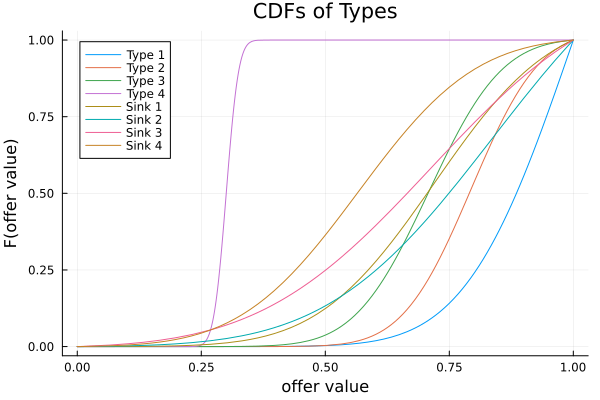

In [39]:
# https://github.com/JuliaPlots/StatsPlots.jl/blob/master/README.md
# https://docs.juliaplots.org/latest/tutorial/

select_type = 1
cdfs = plot(truncated(Normal(sol[2k-1+select_type], sol[2k-1+select_type+K]), 0, 1), func = cdf, title = "CDFs of Types", label = "Type 1")
for select_type in 2:NUMBER_OF_TYPES # academic types
    plot!(cdfs, truncated(Normal(sol[2k-1+select_type], sol[2k-1+select_type+K]), 0, 1), func = cdf, label = string("Type ", select_type))
end

for select_type in k+1:K # sinks
    plot!(cdfs, truncated(Normal(sol[2k-1+select_type], sol[2k-1+select_type+K]), 0, 1), func = cdf, label = string("Sink ", select_type - k))
end
xlabel!(cdfs, "offer value")
ylabel!(cdfs, "F(offer value)")
savefig(cdfs, "cdfs.png")
cdfs

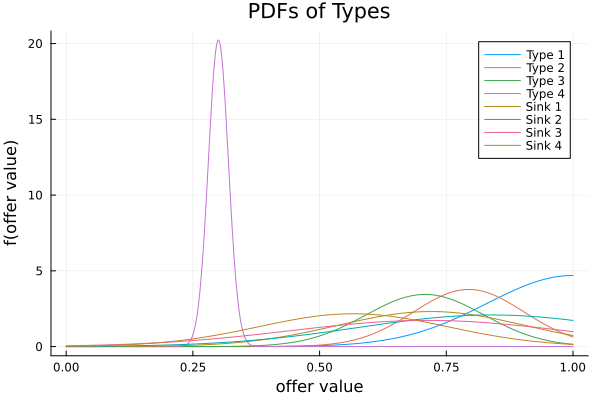

In [40]:
select_type = 1
pdfs = plot(truncated(Normal(sol[2k-1+select_type], sol[2k-1+select_type+K]), 0, 1), func = pdf, title = "PDFs of Types", label = "Type 1")
for select_type in 2:k # academic types
    plot!(pdfs, truncated(Normal(sol[2k-1+select_type], sol[2k-1+select_type+K]), 0, 1), func = pdf, label = string("Type ", select_type))
end

for select_type in k+1:K # sinks
    plot!(pdfs, truncated(Normal(sol[2k-1+select_type], sol[2k-1+select_type+K]), 0, 1), func = pdf, label = string("Sink ", select_type - k))
end
xlabel!(pdfs, "offer value")
ylabel!(pdfs, "f(offer value)")
savefig(pdfs, "pdfs.png")
pdfs

Below is the coarse-grained type allocation from before:

In [41]:
for sorted_type in 1:NUMBER_OF_TYPES+NUMBER_OF_SINKS
    counter = 0
    inst_hold = []
    println("TYPE $sorted_type:")
    for (i, sbm_type) in enumerate(sorted_allocation)
        if sbm_type == sorted_type
            push!(inst_hold, institutions[i])
            counter += 1
        end
    end
    for inst in sort(inst_hold)
        println("  ", inst)
    end
    println("Total Institutions: $counter")
    println()
end

TYPE 1:
  Boston University
  Brown University
  Columbia University
  Cornell University
  Duke University
  Harvard University
  London School of Economics and Political Science
  Massachusetts Institute of Technology
  New York University
  Northwestern University
  Ohio State University
  Pennsylvania State University
  Princeton University
  Stanford University
  University of California Los Angeles (UCLA)
  University of California, Berkeley
  University of Chicago
  University of Maryland
  University of Michigan
  University of Minnesota, Twin Cities
  University of Pennsylvania
  University of Toronto
  University of Wisconsin, Madison
  Yale University
Total Institutions: 24

TYPE 2:
  Arizona State University
  Bocconi University
  Boston College
  Carnegie Mellon University
  Chinese University of Hong Kong
  Clemson University
  Erasmus University Rotterdam
  European University Institute
  George Washington University
  Georgetown University
  Hong Kong University of Scie

One more thing we can do is to estimate a fine-grained department ranking using the estimated values.

In [42]:
est_values = ones(k)
v_base = 1
for i in 1:k-1
    v_base = sol[i] * v_base
    est_values[i+1] = v_base
end
est_values

4-element Vector{Float64}:
 1.0
 0.3996906782903224
 0.27505684038465933
 0.19047391644324801

We can rank departments by the total expected value of their graduates:

In [43]:
valued_indices = []
for i in 1:size(out)[2]
    total_graduate_value = est_values[sorted_allocation[i]] * sum(out[:, i])
    push!(valued_indices, (institutions[i], total_graduate_value))
end
sort!(valued_indices, by = x -> x[2], rev = true)
for (j, entry) in enumerate(valued_indices)
    println("$(j). $(entry[1]) ($(entry[2]))")
end

1. Harvard University (398.0)
2. University of Michigan (313.0)
3. University of California, Berkeley (301.0)
4. Stanford University (284.0)
5. University of Maryland (259.0)
6. Yale University (247.0)
7. University of Pennsylvania (235.0)
8. University of Chicago (232.0)
9. University of Wisconsin, Madison (223.0)
10. University of California Los Angeles (UCLA) (222.0)
11. Princeton University (221.0)
12. Columbia University (220.0)
13. Northwestern University (199.0)
14. Duke University (196.0)
15. New York University (188.0)
16. London School of Economics and Political Science (167.0)
17. Boston University (165.0)
18. Pennsylvania State University (150.0)
19. Ohio State University (149.0)
20. Massachusetts Institute of Technology (131.0)
21. Cornell University (127.0)
22. University of Toronto (126.0)
23. Brown University (122.0)
24. University of Minnesota, Twin Cities (120.0)
25. Washington University in St. Louis (43.16659325535482)
26. University of Oxford (41.16813986390321)
27

or by the total expected value of their hires:

In [44]:
valued_indices_hire = []
for i in 1:size(out)[2]
    total_hire_value = 0
    for j in 1:size(out)[2]
        total_hire_value += est_values[sorted_allocation[j]] * out[i, j]
    end
    push!(valued_indices_hire, (institutions[i], total_hire_value))
end
sort!(valued_indices_hire, by = x -> x[2], rev = true)
for (j, entry) in enumerate(valued_indices_hire)
    println("$(j). $(entry[1]) ($(entry[2]))")
end

1. University of Chicago (90.08853602601418)
2. Harvard University (54.27351023183626)
3. Columbia University (52.998453391451605)
4. New York University (52.42238662576686)
5. University of Pennsylvania (51.998453391451605)
6. University of Toronto (51.56971641114908)
7. Shanghai University of Finance and Economics (50.78133966652051)
8. Northwestern University (50.66460279169887)
9. University of Michigan (50.34794842880157)
10. National University of Singapore (48.409148681693985)
11. University of California Los Angeles (UCLA) (47.4481757903402)
12. Stanford University (47.0)
13. Peking University (44.51952077020874)
14. Cornell University (44.059653644344024)
15. University of British Columbia (42.988308664475504)
16. Chinese University of Hong Kong (42.770335054568434)
17. Renmin University (39.582267631649536)
18. University of California, Berkeley (36.47412887525562)
19. University of Maryland (36.199072034870966)
20. Pennsylvania State University (36.064293469989195)
21. Arizo